### Name: Swathi Subramanyam Pabbathi

### Date: 12/05/2025

### Implementation of object detection using Faster R-CNN pretrained Model.

#### Install and Importing all necessary libraries and packages

In [15]:
!pip install opencv-python albumentations

In [3]:
!pip install pycocotools

  Using cached pycocotools-2.0.10-cp312-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
Using cached pycocotools-2.0.10-cp312-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (397 kB)


In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: Tesla V100-SXM2-16GB


In [5]:
!pip install opencv-python matplotlib

In [6]:
!pip install albumentations --quiet

In [7]:
!pip install numpy==1.26.4 pandas==1.5.3 pydynamodb roboflow --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 173.2 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 256.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 231.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 551.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 213.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 159.0 MB/s  0:00:00
  Created wheel for pandas: filename=pandas-1.5.3-cp312-cp312-linux_x86_64.whl size=11719659 sha256=845cf6f53faefa4035d2f32438a345732f261ef8cca337646419d8b9315c1cee
  Stored in directory: /tmp/pip-ephem-wheel-cache-_uua_x4t/wheels/fb/83/18/8e7307aa1185c5498c5490e4d9c8a1732d9f1056e86c3491c6
Successfully built pandas
  Attempting uninstall: numpym━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  2/10 [sqlean.py]


In [16]:
!pip install roboflow --quiet

In [ ]:
%pip uninstall -y matplotlib numpy
%pip install numpy==1.26.4 matplotlib==3.8.4

In [2]:
# Core libraries
import os
import zipfile
import shutil
import random

# Image processing
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import pandas as pd
from roboflow import Roboflow

#### Loading the dataset from Roboflow

In [4]:
from roboflow import Roboflow

rf = Roboflow(api_key="ahWY6fipy725RcLzAuIK")   #  insert your API key
project = rf.workspace("machine-learning-class-eiri5").project("intersection-traffic-piimy")
dataset = project.version(10).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Intersection-Traffic--10 in yolov8:: 100%|██████████| 38762/38762 [00:06<00:00, 5850.08it/s]


In [6]:
yaml_text = """
train: Intersection-Traffic--10/train
val: Intersection-Traffic--10/valid
test: Intersection-Traffic--10/test

nc: 5
names:
  0: bicycle
  1: bus
  2: car
  3: license-plate
  4: motorcycle
"""

with open("Intersection-Traffic--10/data1.yaml", "w") as f:
    f.write(yaml_text)

print(" data1.yaml created successfully!")

 data1.yaml created successfully!


#### Train, Valid and Test splits and their counts

In [7]:
for split in ["train", "valid", "test"]:
    print(f"--- {split.upper()} ---")
    print("Images:", len(os.listdir(f"Intersection-Traffic--10/{split}/images")))
    print("Labels:", len(os.listdir(f"Intersection-Traffic--10/{split}/labels")))
    print()

--- TRAIN ---
Images: 17334
Labels: 17334

--- VALID ---
Images: 1321
Labels: 1321

--- TEST ---
Images: 720
Labels: 720



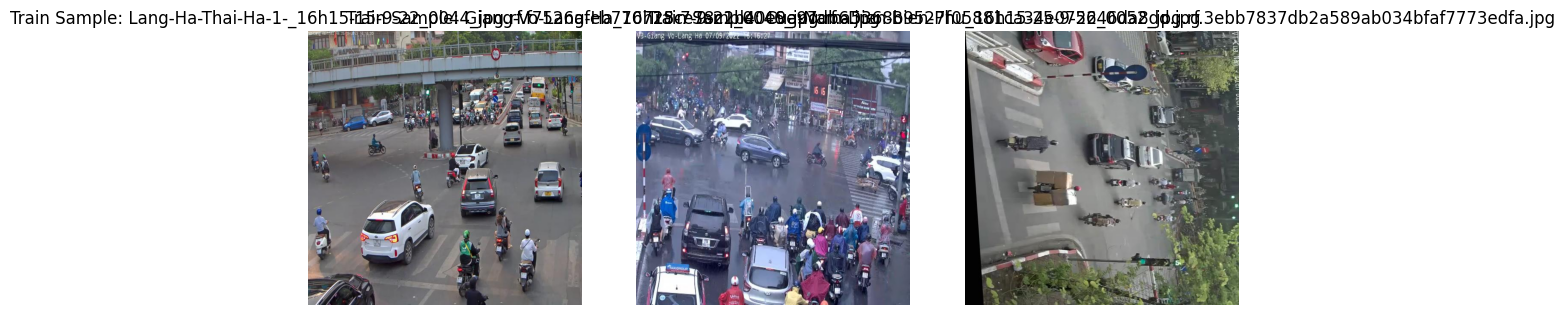

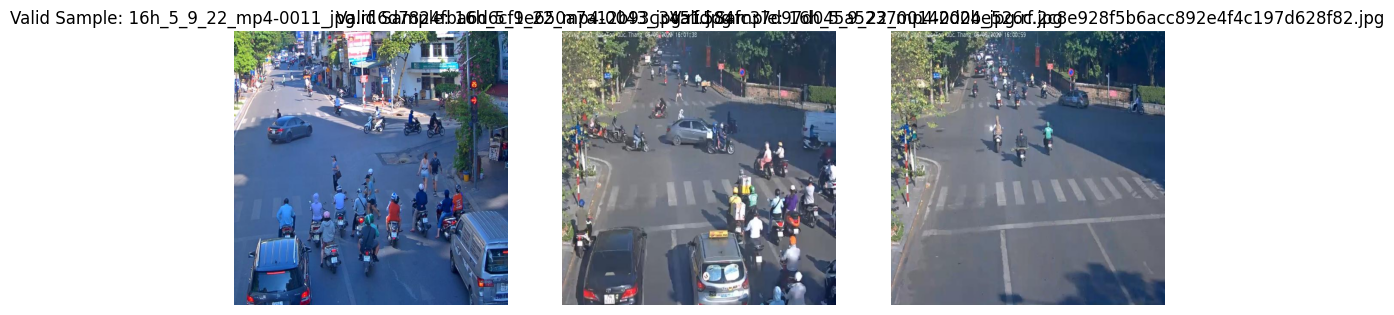

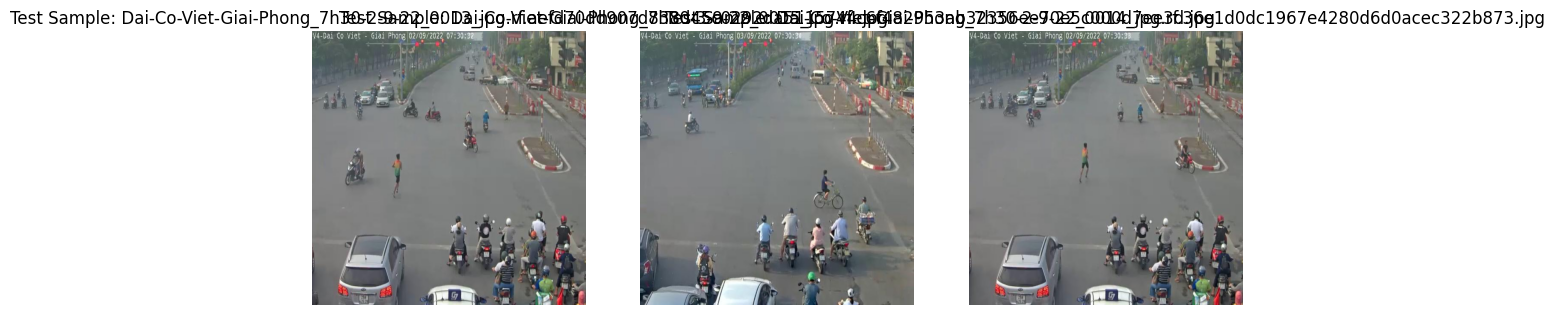

In [8]:
def show_random_images(split_path, title, num_images=3):
    image_dir = os.path.join(split_path, "images")
    image_files = os.listdir(image_dir)
    selected = random.sample(image_files, num_images)

    plt.figure(figsize=(12, 4))
    for i, img_file in enumerate(selected):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{title}: {img_file}")
    plt.show()


# Paths
train_path = "Intersection-Traffic--10/train"
valid_path = "Intersection-Traffic--10/valid"
test_path  = "Intersection-Traffic--10/test"

# Show samples
show_random_images(train_path, "Train Sample")
show_random_images(valid_path, "Valid Sample")
show_random_images(test_path, "Test Sample")

### Image Preprocessing
#### Data Cleaning - Remove corrupted or unreadable images

In [9]:
# Remove Corrupted Images
def find_bad_images(path):
    bad = []
    for f in os.listdir(path):
        img = cv2.imread(os.path.join(path, f))
        if img is None:
            bad.append(f)
    return bad

bad_train = find_bad_images("Intersection-Traffic--10/train/images")
bad_valid = find_bad_images("Intersection-Traffic--10/valid/images")
bad_test  = find_bad_images("Intersection-Traffic--10/test/images")

bad_train, bad_valid, bad_test

([], [], [])

#### Consider a sample subset of train,test and valid datasets

In [10]:
# -----------------------------
# Paths to your existing dataset
# -----------------------------
original_paths = {
    "train": "Intersection-Traffic--10/train",
    "valid": "Intersection-Traffic--10/valid",
    "test": "Intersection-Traffic--10/test"
}

# -----------------------------
# Collect all images into one list
# -----------------------------
all_images = []

for split in original_paths:
    imgs = os.listdir(os.path.join(original_paths[split], "images"))
    imgs = [os.path.join(original_paths[split], "images", f) for f in imgs]
    all_images.extend(imgs)

print("Total images found:", len(all_images))

# -----------------------------
# Sample size (train max = 200)
# -----------------------------
train_size = 1000
total = train_size / 0.70   # train is 70%

valid_size = int(total * 0.15)
test_size = int(total * 0.15)

print("Sampling:")
print("Train:", train_size)
print("Valid:", valid_size)
print("Test :", test_size)

# -----------------------------
# Random sampling
# -----------------------------
random.shuffle(all_images)

train_images = all_images[:train_size]
valid_images = all_images[train_size : train_size + valid_size]
test_images  = all_images[train_size + valid_size : train_size + valid_size + test_size]

# -----------------------------
# Create new dataset folders
# -----------------------------
base = "small_dataset"

for split in ["train", "valid", "test"]:
    os.makedirs(f"{base}/{split}/images", exist_ok=True)
    os.makedirs(f"{base}/{split}/labels", exist_ok=True)

def copy_with_label(img_path, out_split):
    img_name = os.path.basename(img_path)
    lbl_name = img_name.replace(".jpg", ".txt").replace(".png", ".txt")

    # Copy image
    shutil.copy(img_path, f"{base}/{out_split}/images/{img_name}")

    # Copy label from corresponding original folder
    for split in original_paths:
        lbl_path = os.path.join(original_paths[split], "labels", lbl_name)
        if os.path.exists(lbl_path):
            shutil.copy(lbl_path, f"{base}/{out_split}/labels/{lbl_name}")
            return True
    return False

# -----------------------------
# Copy images + labels
# -----------------------------
for img in train_images:
    copy_with_label(img, "train")

for img in valid_images:
    copy_with_label(img, "valid")

for img in test_images:
    copy_with_label(img, "test")

print("\n DONE! Small dataset created at: small_dataset")

Total images found: 19375
Sampling:
Train: 1000
Valid: 214
Test : 214

 DONE! Small dataset created at: /content/small_dataset


In [11]:
yaml_text = """
train: small_dataset/train/images
val: small_dataset/valid/images
test: small_dataset/test/images

nc: 5
names:
  0: bicycle
  1: bus
  2: car
  3: license-plate
  4: motorcycle
"""

with open("data2.yaml", "w") as f:
    f.write(yaml_text)

print(" data2.yaml created successfully!")

 data2.yaml created successfully!


#### Show Invalid/missing Labels, Display Image, and Delete Files

YOLO model suffers if there are invalid or missing labels in the image hence cleanup is essential


 Checking labels in: small_dataset/train
 Invalid label files: ['Pho-Hue-Tran-Khat-Chan_7h30-1-9-22_0031_jpg.rf.80325e2ba3bc08c677df5a72e6f370ed.txt', 'Pho-Hue-Tran-Khat-Chan_7h30-1-9-22_0031_jpg.rf.d93271471ceab7278e268ff152903048.txt']


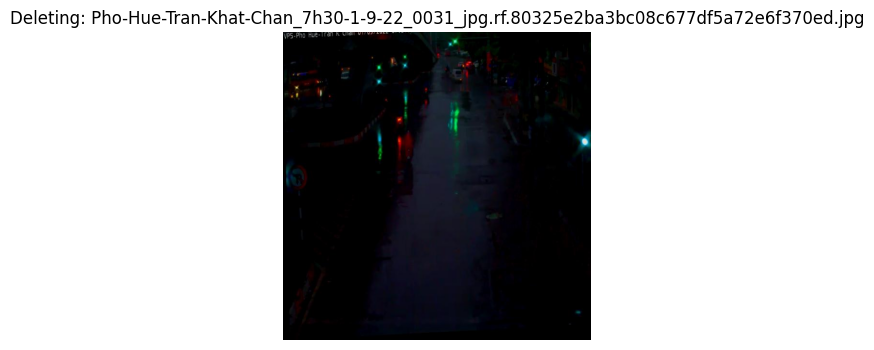

 Deleted image: small_dataset/train/images/Pho-Hue-Tran-Khat-Chan_7h30-1-9-22_0031_jpg.rf.80325e2ba3bc08c677df5a72e6f370ed.jpg
 Deleted label: small_dataset/train/labels/Pho-Hue-Tran-Khat-Chan_7h30-1-9-22_0031_jpg.rf.80325e2ba3bc08c677df5a72e6f370ed.txt


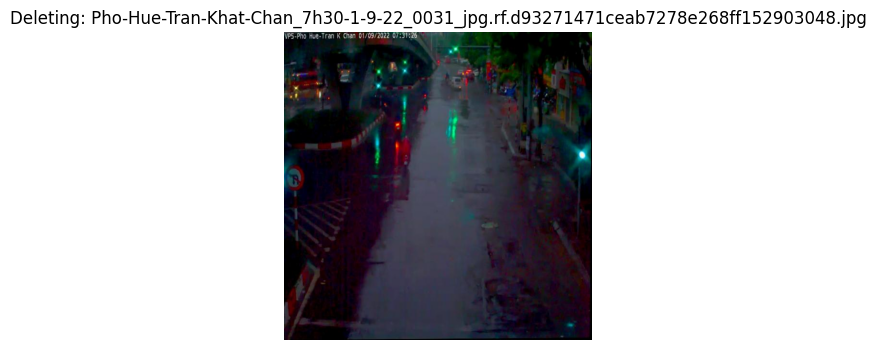

 Deleted image: small_dataset/train/images/Pho-Hue-Tran-Khat-Chan_7h30-1-9-22_0031_jpg.rf.d93271471ceab7278e268ff152903048.jpg
 Deleted label: small_dataset/train/labels/Pho-Hue-Tran-Khat-Chan_7h30-1-9-22_0031_jpg.rf.d93271471ceab7278e268ff152903048.txt
 Cleanup complete for: small_dataset/train

 Checking labels in: small_dataset/valid
 Invalid label files: []
 Cleanup complete for: small_dataset/valid

 Checking labels in: small_dataset/test
 Invalid label files: []
 Cleanup complete for: small_dataset/test


In [12]:
def check_label_file(path):
    """Returns False if label file contains invalid YOLO bounding boxes."""
    try:
        with open(path) as f:
            lines = f.read().strip().split("\n")

        for l in lines:
            parts = l.split()
            if len(parts) != 5:
                return False

            cls, x, y, w, h = map(float, parts)
            if not (0 <= x <= 1 and 0 <= y <= 1 and w > 0 and h > 0):
                return False

    except:
        return False

    return True


# --------------------------------------------------------------
# Function to clean a dataset split (train, valid, test)
# --------------------------------------------------------------
def clean_split(split_path):
    label_dir = f"{split_path}/labels"
    image_dir = f"{split_path}/images"

    invalid = []

    print(f"\n Checking labels in: {split_path}")

    # Find invalid labels
    for f in os.listdir(label_dir):
        lbl_path = os.path.join(label_dir, f)
        if not check_label_file(lbl_path):
            invalid.append(f)

    print(" Invalid label files:", invalid)

    # Display and delete invalid images + labels
    for lbl_file in invalid:
        # Match image name (.jpg or .png)
        img_base = lbl_file.replace(".txt", "")
        img_jpg = os.path.join(image_dir, img_base + ".jpg")
        img_png = os.path.join(image_dir, img_base + ".png")

        img_path = img_jpg if os.path.exists(img_jpg) else img_png
        lbl_path = os.path.join(label_dir, lbl_file)

        # Display image if present
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Deleting: {os.path.basename(img_path)}")
            plt.axis("off")
            plt.show()

        # Delete image
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f" Deleted image: {img_path}")

        # Delete label
        if os.path.exists(lbl_path):
            os.remove(lbl_path)
            print(f" Deleted label: {lbl_path}")

    print(" Cleanup complete for:", split_path)


# --------------------------------------------------------------
# Run cleaning for all dataset splits
# --------------------------------------------------------------

base = "small_dataset"

for split in ["train", "valid", "test"]:
    clean_split(f"{base}/{split}")

#### Finding Class Imbalance

In [13]:
import os
from collections import Counter

counter = Counter()

for split in ["train", "valid", "test"]:
    label_dir = f"small_dataset/{split}/labels"
    for f in os.listdir(label_dir):
        with open(f"{label_dir}/{f}") as lbl:
            for line in lbl:
                cls = int(line.split()[0])
                counter[cls] += 1

counter

Counter({4: 16119, 2: 5194, 1: 286, 0: 182, 3: 90})

In [14]:
import shutil

# Folder you want to zip
folder_path = "small_dataset"
output_zip = "small_dataset.zip"   # name of zip file

# Create zip archive
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', folder_path)

print(" Zip file created:", output_zip)

 Zip file created: small_dataset.zip


#### Converting the YOLO format dataset to COCO format suitable for Faster RCNN

In [40]:
import os
import json
import cv2

# Base path
BASE_PATH = "small_dataset"

CLASS_NAMES = [
    "bicycle",
    "bus",
    "car",
    "license-plate",
    "motorcycle"
]

def yolo_to_coco(split="train"):
    print(f"\nConverting {split} to COCO format...")

    images_dir = os.path.join(BASE_PATH, split, "images")
    labels_dir = os.path.join(BASE_PATH, split, "labels")
    output_file = os.path.join(BASE_PATH, f"{split}_coco.json")

    coco = {
    "info": {
        "description": "Small vehicle dataset",
        "version": "1.0",
        "year": 2025,
        "contributor": "Swathi",
        "date_created": "2025-01-01"
    },
    "licenses": [
        {
            "id": 1,
            "name": "Unknown",
            "url": ""
        }
    ],
    "images": [],
    "categories": [],
    "annotations": []
    }

    # categories
    for idx, name in enumerate(CLASS_NAMES):
        coco["categories"].append({
            "id": idx,
            "name": name
        })

    annotation_id = 1
    image_id = 1

    for filename in os.listdir(images_dir):
        if not filename.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(images_dir, filename)
        label_path = os.path.join(labels_dir, filename.rsplit(".",1)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w = img.shape[:2]

        coco["images"].append({
            "id": image_id,
            "file_name": filename,
            "width": w,
            "height": h
        })

        with open(label_path) as f:
            lines = f.readlines()

        for line in lines:
            values = line.strip().split()
            if len(values) != 5:
                continue

            cls, xc, yc, bw, bh = values
            cls = int(cls)
            xc, yc, bw, bh = map(float, (xc, yc, bw, bh))

            # Normalize --> absolute
            x_center = xc * w
            y_center = yc * h
            width = bw * w
            height = bh * h

            x_min = x_center - (width / 2)
            y_min = y_center - (height / 2)

            if width <= 0 or height <= 0:
                continue

            coco["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": cls,
                "bbox": [
                    round(x_min, 2),
                    round(y_min, 2),
                    round(width, 2),
                    round(height, 2)
                ],
                "area": round(width * height, 2),
                "iscrowd": 0
            })

            annotation_id += 1

        image_id += 1

    with open(output_file, "w") as f:
        json.dump(coco, f, indent=4)

    print(f" COCO file generated -> {output_file}")
    print(f"Images: {len(coco['images'])}, Annotations: {len(coco['annotations'])}")


# Run for all splits
for split in ["train", "valid", "test"]:
    yolo_to_coco(split)


Converting train to COCO format...
 COCO file generated -> small_dataset/train_coco.json
Images: 998, Annotations: 15328

Converting valid to COCO format...
 COCO file generated -> small_dataset/valid_coco.json
Images: 214, Annotations: 3410

Converting test to COCO format...
 COCO file generated -> small_dataset/test_coco.json
Images: 214, Annotations: 3133


In [ ]:
pip install pycocotools matplotlib opencv-python


Showing 3 images from TRAIN set
Annotation file: small_dataset/train_coco.json
Image folder: small_dataset/train/images
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Trying: small_dataset/train/images/Nguyen-Thai-Hoc-Trinh-Hoai-Duc_16h-30-15-9-22_0060_jpg.rf.1339dff961a5801fdb952b6c11f2e7a2.jpg


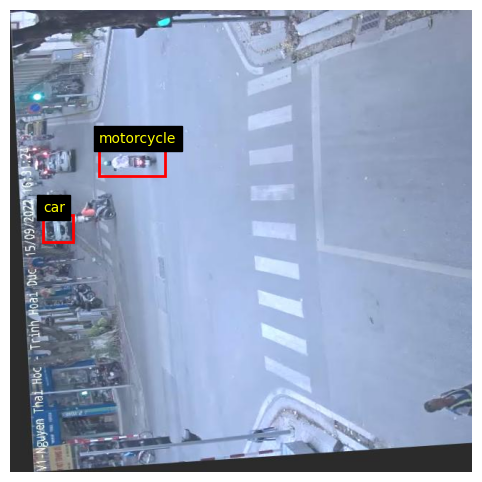

Trying: small_dataset/train/images/Giang-Vo-Lang-Ha_16h30-25-9-22_0053_jpg.rf.ab9f59d6f0f3ebc4305cf38cd69839bb.jpg


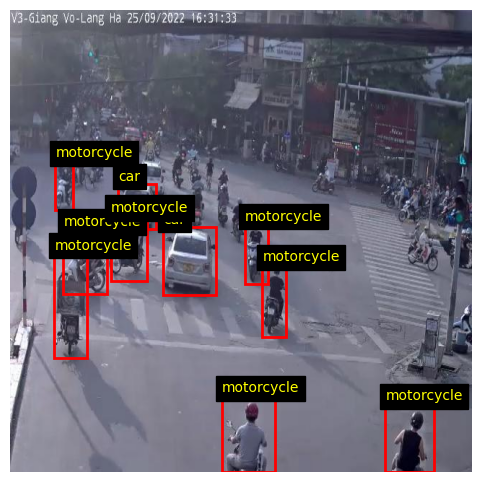

Trying: small_dataset/train/images/Ly-Thuong-Kiet-Hang-Bai_16h-30-15-9-22_0052_jpg.rf.0b1268933401085c4d2f76b1f52700d5.jpg


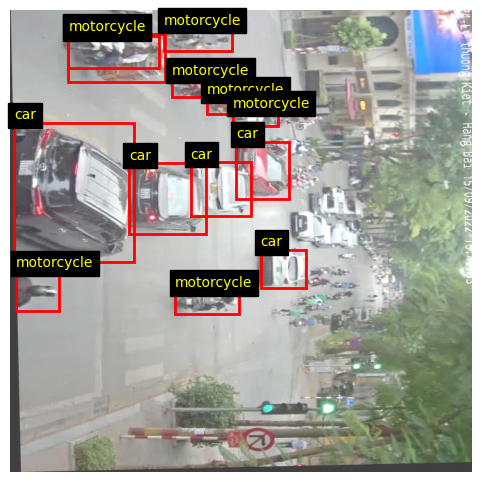


Showing 3 images from VALID set
Annotation file: small_dataset/valid_coco.json
Image folder: small_dataset/valid/images
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Trying: small_dataset/valid/images/Dai-Co-Viet-Giai-Phong_7h-9-9-22_0059_jpg.rf.64b3e2e6aa70c9cbf2a1b25f4b0f2832.jpg


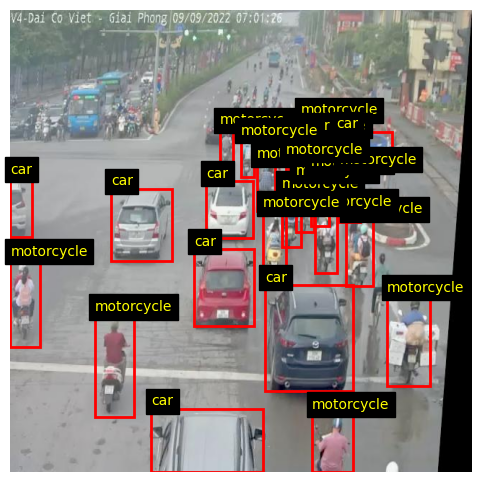

Trying: small_dataset/valid/images/Pho-Hue-Tran-Khat-Chan_7h29-26-9-22_0045_jpg.rf.33497c5176b8cc894969a88d479bc9f1.jpg


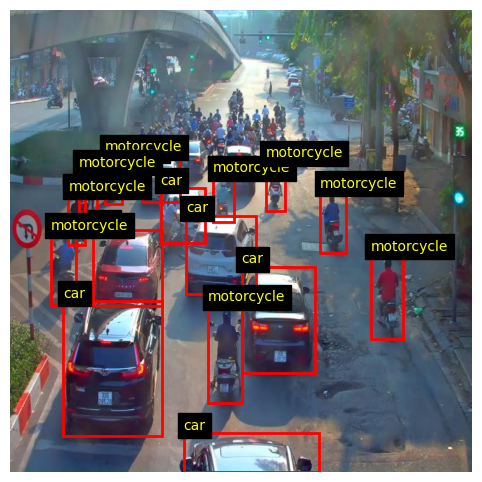

Trying: small_dataset/valid/images/Le-Duan-Nguyen-Thai-Hoc_16h30-5-9-22_0027_jpg.rf.1df8e6154963af5fcbb3514edd654fb0.jpg


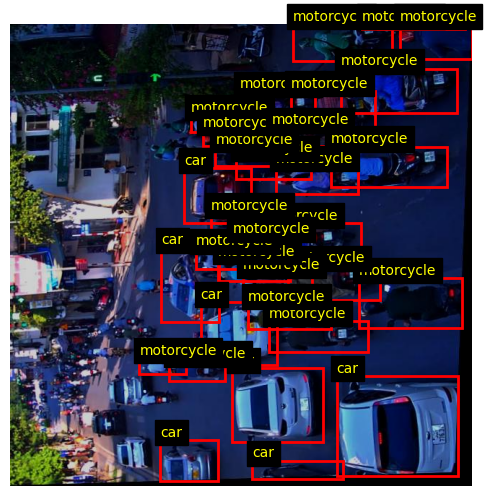


Showing 3 images from TEST set
Annotation file: small_dataset/test_coco.json
Image folder: small_dataset/test/images
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Trying: small_dataset/test/images/Le-Duan-Nguyen-Thai-Hoc_16h15-15-9-22_0053_jpg.rf.2517be9d5c5c5b6fa896e0d197111041.jpg


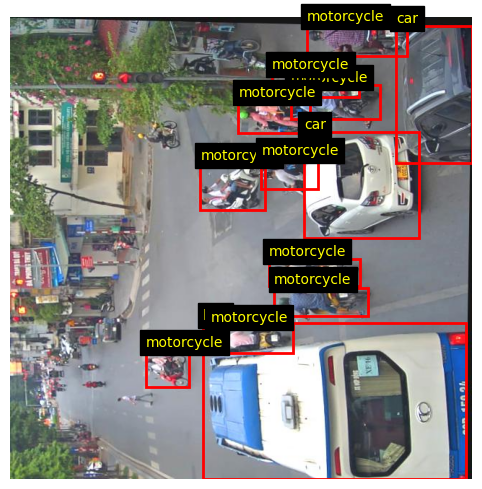

Trying: small_dataset/test/images/Cua-Nam-Dien-Bien-Phu_16h-5-9-22_0030_jpg.rf.9110edba67ba0ba37e041dd75b56c612.jpg


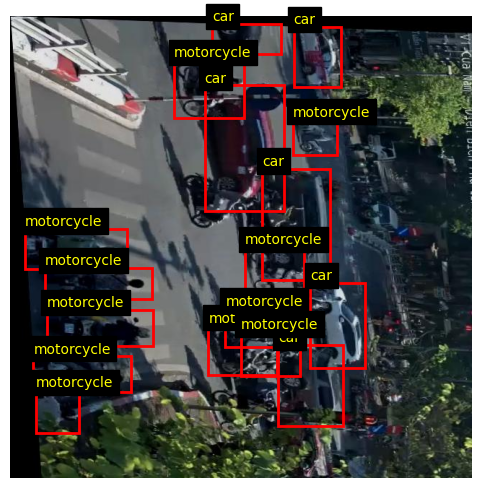

Trying: small_dataset/test/images/Pho-Hue-Tran-Khat-Chan_7h30-4-9-22_0055_jpg.rf.add464e2d090f430913af910bbfecaf6.jpg


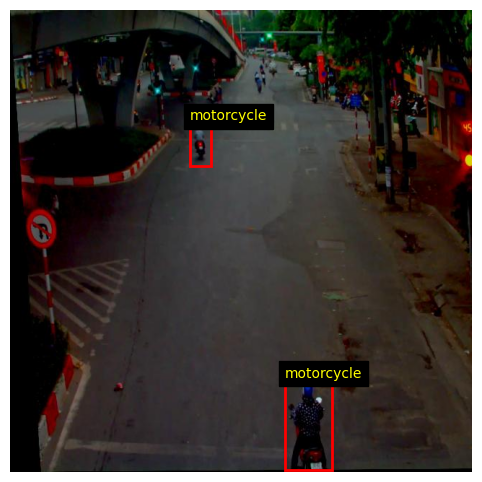

In [42]:
show_coco_images("train", 3)
show_coco_images("valid", 3)
show_coco_images("test", 3)

#### Plot the class Imbalance on classes.


 Class distribution in TRAIN set:

motorcycle           : 11352
car                  : 3594
bus                  : 1930
bicycle              : 1875
license-plate        : 64


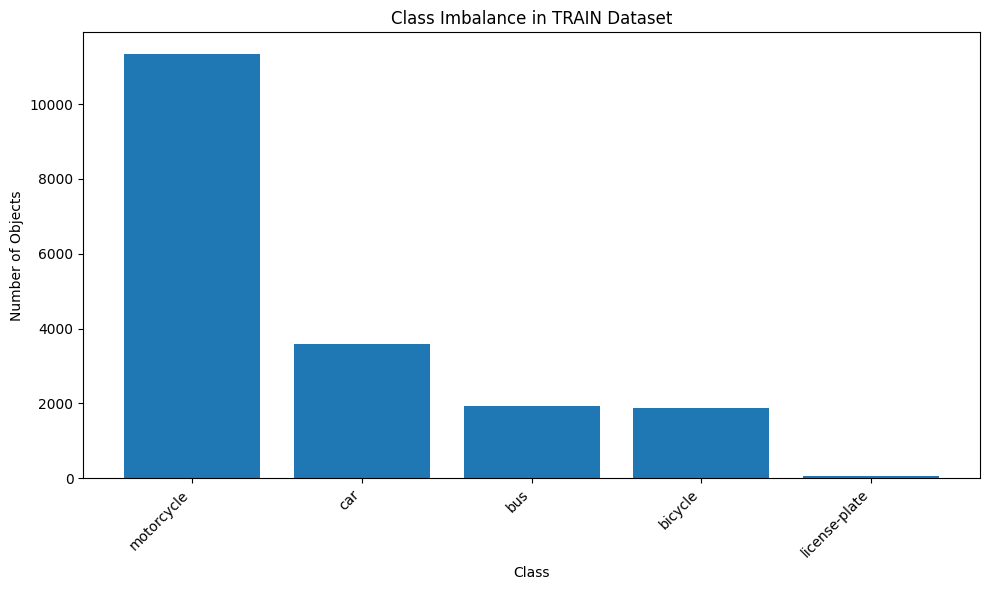

In [43]:
import json
from collections import Counter
import matplotlib.pyplot as plt

train_json = "small_dataset/train_coco_balanced.json"

# Load COCO file
with open(train_json, "r") as f:
    coco = json.load(f)

# Build category id -> name mapping
categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Count instances per category
class_counts = Counter()

for ann in coco["annotations"]:
    cat_id = ann["category_id"]
    class_counts[categories[cat_id]] += 1

# Sort for better readability
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

print("\n Class distribution in TRAIN set:\n")
for cls, count in class_counts.items():
    print(f"{cls:20} : {count}")

# Plot class imbalance
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha="right")
plt.title("Class Imbalance in TRAIN Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Objects")
plt.tight_layout()
plt.show()

#### Oversampling the minority classes to some extent

In [44]:
import json
import copy

# Input / Output paths
INPUT_JSON  = "small_dataset/train_coco.json"
OUTPUT_JSON = "small_dataset/train_coco_balanced.json"

BICYCLE_MULTIPLIER = 15
BUS_MULTIPLIER = 10

with open(INPUT_JSON, "r") as f:
    coco = json.load(f)

# Build category id → name
categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Separate original annotations
original_anns = coco["annotations"]

# Find max annotation id (for new ids)
max_id = max([ann["id"] for ann in original_anns])

new_annotations = []
current_id = max_id + 1

for ann in original_anns:

    # Copy original annotation
    new_annotations.append(ann)

    class_name = categories[ann["category_id"]]

    # Oversample bicycle
    if class_name == "bicycle":
        for _ in range(BICYCLE_MULTIPLIER - 1):
            duplicate = copy.deepcopy(ann)
            duplicate["id"] = current_id
            current_id += 1
            new_annotations.append(duplicate)

    # Oversample bus
    elif class_name == "bus":
        for _ in range(BUS_MULTIPLIER - 1):
            duplicate = copy.deepcopy(ann)
            duplicate["id"] = current_id
            current_id += 1
            new_annotations.append(duplicate)

# Replace annotations
coco["annotations"] = new_annotations

# Save balanced file
with open(OUTPUT_JSON, "w") as f:
    json.dump(coco, f)

print(" Balancing complete!")
print("Saved as:", OUTPUT_JSON)
print("Original annotations:", len(original_anns))
print("New annotations:", len(new_annotations))

 Balancing complete!
Saved as: small_dataset/train_coco_balanced.json
Original annotations: 15328
New annotations: 18815


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Random image: small_dataset/train/images/Giang-Vo-Lang-Ha_16h-30-7-9-22_0022_jpg.rf.4f0c6d1faf999a0a71a54bc1a229e35c.jpg


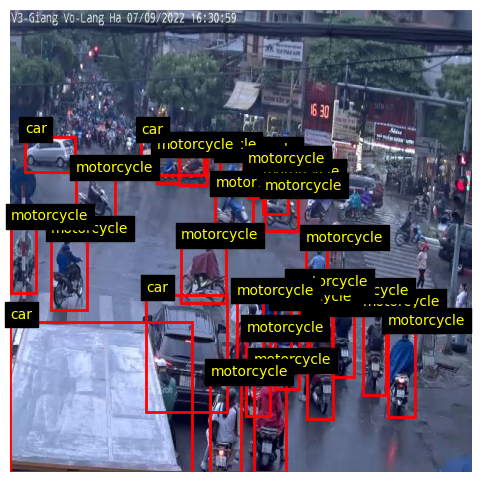

In [45]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

BASE_PATH = "small_dataset"

# Paths
ann_file = os.path.join(BASE_PATH, "train_coco_balanced.json")
img_dir  = os.path.join(BASE_PATH, "train", "images")

# Load COCO
coco = COCO(ann_file)

# Pick random image id
img_id = random.choice(coco.getImgIds())
img_info = coco.loadImgs(img_id)[0]
file_name = img_info["file_name"]

# Make sure we use only filename (ignore any path in JSON)
img_path = os.path.join(img_dir, os.path.basename(file_name))

print("Random image:", img_path)

# Read image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get annotations
ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)

# Plot
plt.figure(figsize=(8,6))
plt.imshow(image)
plt.axis("off")

for ann in anns:
    x, y, w, h = ann["bbox"]

    # draw box
    rect = plt.Rectangle(
        (x, y), w, h,
        fill=False,
        edgecolor="red",
        linewidth=2
    )
    plt.gca().add_patch(rect)

    # category name
    cat = coco.loadCats([ann["category_id"]])[0]["name"]

    plt.text(
        x, y-5,
        cat,
        color="yellow",
        fontsize=10,
        backgroundcolor="black"
    )

plt.show()

#### Model Training

In [25]:
pip install torch torchvision pycocotools albumentations opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [46]:
# Create a COCO Dataset class (for Faster R-CNN)
import os
import torch
import cv2
import numpy as np
from pycocotools.coco import COCO

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]

        # Load image
        img_info = coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.img_dir, img_info['file_name'])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize to 800x800
        image = cv2.resize(image, (640, 640))

        # Get annotations
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        for ann in annotations:
            x, y, w, h = ann['bbox']
            x2 = x + w
            y2 = y + h

            boxes.append([x, y, x2, y2])
            labels.append(ann['category_id'] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Clamp boxes inside image boundaries
        H, W = image.shape[:2]  # image is still numpy here
        boxes[:, 0::2] = boxes[:, 0::2].clamp(0, W)   # x1, x2
        boxes[:, 1::2] = boxes[:, 1::2].clamp(0, H)   # y1, y2

        # REMOVE INVALID BOXES (THIS WAS MISSING)
        if boxes.numel() > 0:
            keep = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            boxes = boxes[keep]
            labels = labels[keep]

        # If no valid boxes remain → skip this image safely
        if boxes.numel() == 0:
            return self.__getitem__((index + 1) % len(self))

        image_id = torch.tensor([img_id])

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
        }

        # image = cv2.resize(image, (800, 800))   # important
        image = torch.tensor(image / 255., dtype=torch.float32).permute(2, 0, 1)

        return image, target

In [47]:
import albumentations as A

train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.MotionBlur(p=0.2),
        A.GaussianBlur(p=0.2),
        A.Affine(
            translate_percent=0.05,
            scale=(0.9, 1.1),
            rotate=(-10, 10),
            p=0.5
        )
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",    # x1, y1, x2, y2
        label_fields=["labels"]
    )
)

In [49]:
# Load train datasets
from torch.utils.data import DataLoader

train_dataset = CocoDataset(
    img_dir="small_dataset/train/images",
    ann_file="small_dataset/train_coco_balanced.json",
    transforms=train_transforms                    # Augmentation
)

valid_dataset = CocoDataset(
    img_dir="small_dataset/valid/images",
    ann_file="small_dataset/valid_coco.json"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [50]:
# Load pre-trained Faster R-CNN model
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [51]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 1 + len(CLASS_NAMES)  # background + 5 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#### Claculating  the losses and IoU of trained dataset and validation dataset after the training completes

In [52]:
def calculate_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return inter_area / (box1_area + box2_area - inter_area + 1e-6)


def evaluate_loss(model, dataloader, device):
    model.train()
    total_loss = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            total_loss += losses.item()

    return total_loss / len(dataloader)



def evaluate_iou(model, dataloader, device, max_preds=20):
    model.eval()
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, targets in dataloader:

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):

                pred_boxes = output['boxes'].cpu().numpy()
                true_boxes = target['boxes'].cpu().numpy()

                pred_boxes = pred_boxes[:max_preds]
                true_boxes = true_boxes[:max_preds]

                for tb in true_boxes:

                    if len(pred_boxes) == 0:
                        continue

                    ious = [calculate_iou(pb, tb) for pb in pred_boxes]
                    max_iou = max(ious)

                    total_iou += max_iou
                    count += 1

    if count == 0:
        return 0

    return total_iou / count

In [53]:
from pycocotools.cocoeval import COCOeval
import numpy as np

def evaluate_map(model, dataloader, device, coco_gt, iou_type="bbox", conf_thresh=0.5):
    model.eval()
    results = []

    with torch.no_grad():
        for images, targets in dataloader:

            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):

                image_id = target["image_id"].item()

                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):

                    if score < conf_thresh:
                        continue

                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1

                    results.append({
                        "image_id": image_id,
                        "category_id": int(label - 1),  # convert 1–5 back to 0–4
                        "bbox": [float(x1), float(y1), float(width), float(height)],
                        "score": float(score)
                    })

    if len(results) == 0:
        return 0.0

    coco_pred = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_pred, iou_type)

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # mAP@[.5:.95] -> first value
    return coco_eval.stats[0]

In [54]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### Hyperparameter tuning

In [55]:
import torch

# Only train parameters that require gradients
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.0001,
    momentum=0.9,
    weight_decay=0.00005
)

In [56]:
from pycocotools.coco import COCO

coco_gt = COCO("small_dataset/valid_coco.json")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [57]:
train_losses = []
val_losses = []
train_ious = []
val_ious = []
val_maps = [] 

#### training the model for 40 epochs and desired hyperparameters tuned

In [59]:
num_epochs = 40

for epoch in range(num_epochs):

    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0

    for images, targets in train_loader:

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    train_loss /= len(train_loader)

    # ---------------- VALIDATION LOSS ----------------
    val_loss = evaluate_loss(model, valid_loader, device)

    # ---------------- IOU ----------------
    train_iou = evaluate_iou(model, train_loader, device)
    val_iou   = evaluate_iou(model, valid_loader, device)

    # ---------------- mAP (VALID ONLY) ----------------
    val_map = evaluate_map(model, valid_loader, device, coco_gt)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    val_maps.append(val_map)

    # Print everything in ONE line
    print(
        f"Epoch {epoch+1:02d}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Train IoU: {train_iou:.4f} | "
        f"Val IoU: {val_iou:.4f} | "
        f"Val mAP: {val_map:.4f}"
    )

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.07s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

#### Visualize the loss and IoU curves of training and validation datasets

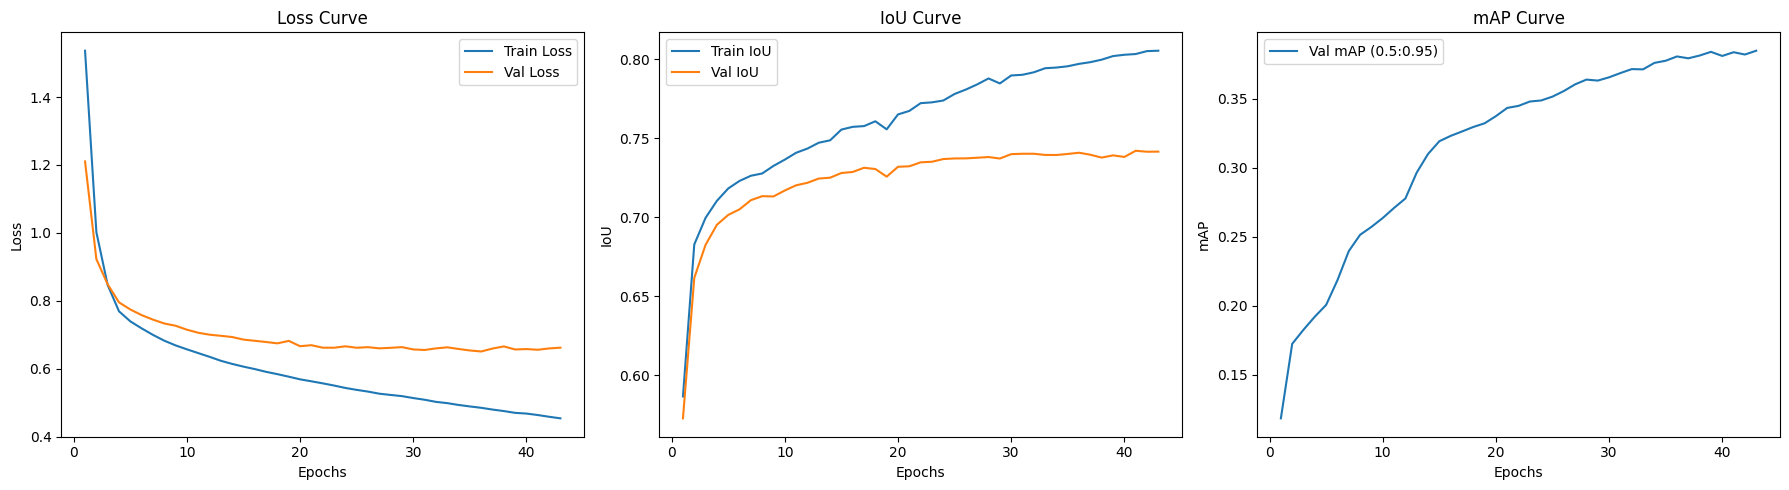

In [61]:
import matplotlib.pyplot as plt

n_epochs = min(
    len(train_losses),
    len(val_losses),
    len(train_ious),
    len(val_ious),
    len(val_maps)
)

epochs = range(1, n_epochs + 1)

plt.figure(figsize=(18,5))

# -------- LOSS --------
plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# -------- IOU --------
plt.subplot(1,3,2)
plt.plot(epochs, train_ious, label="Train IoU")
plt.plot(epochs, val_ious, label="Val IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.title("IoU Curve")
plt.legend()

# -------- mAP --------
plt.subplot(1,3,3)
plt.plot(epochs, val_maps, label="Val mAP (0.5:0.95)")
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("mAP Curve")
plt.legend()

plt.tight_layout()
plt.show()

#### Save the model

In [63]:
# Save best model based on validation mAP

torch.save(model.state_dict(), "best_faster_rcnn_vehicle_detector.pt")
print("Best model updated & saved")

Best model updated & saved


In [64]:
test_dataset = CocoDataset(
    img_dir="small_dataset/test/images",
    ann_file="small_dataset/test_coco.json"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


#### Model evaluation on Test dataset

In [65]:
# ---------------- Load BEST model ----------------
model.load_state_dict(torch.load("best_faster_rcnn_vehicle_detector.pt"))
model.to(device)
model.eval()

# ---------------- Load COCO test ground truth ----------------
from pycocotools.coco import COCO
coco_test = COCO("small_dataset/test_coco.json")

# Patch if needed (for COCOeval safety)
if "info" not in coco_test.dataset:
    coco_test.dataset["info"] = {}
if "licenses" not in coco_test.dataset:
    coco_test.dataset["licenses"] = []

# ---------------- TEST METRICS ----------------

# 1. Test Loss
test_loss = evaluate_loss(model, test_loader, device)

# 2. Test IoU
test_iou = evaluate_iou(model, test_loader, device)

# 3. Test mAP
test_map = evaluate_map(model, test_loader, device, coco_test)

# ---------------- PRINT RESULTS ----------------
print("\n================== FINAL TEST RESULTS ==================")
print(f"Test Loss : {test_loss:.4f}")
print(f"Test IoU  : {test_iou:.4f}")
print(f"Test mAP  : {test_map:.4f}")
print("========================================================\n")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.94s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

#### Evalauation Metrics - Classification Report

In [66]:
from sklearn.metrics import classification_report

def get_detection_classification_data(model, dataloader, device, iou_threshold=0.5, conf_threshold=0.5):

    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets in dataloader:

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):

                pred_boxes = output["boxes"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()

                true_boxes = target["boxes"].cpu().numpy()
                true_labels = target["labels"].cpu().numpy()

                matched_true = set()

                for i, (pb, pl, ps) in enumerate(zip(pred_boxes, pred_labels, pred_scores)):

                    if ps < conf_threshold:
                        continue

                    best_iou = 0
                    best_gt_idx = -1

                    for j, tb in enumerate(true_boxes):
                        if j in matched_true:
                            continue

                        iou = calculate_iou(pb, tb)

                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = j

                    if best_iou >= iou_threshold and best_gt_idx != -1:
                        # true positive
                        y_true.append(true_labels[best_gt_idx])
                        y_pred.append(pl)
                        matched_true.add(best_gt_idx)

                    else:
                        # false positive (no good match)
                        y_true.append(0)   # background
                        y_pred.append(pl)

                # false negatives (missed objects)
                for j, tl in enumerate(true_labels):
                    if j not in matched_true:
                        y_true.append(tl)
                        y_pred.append(0)   # predicted as background

    return y_true, y_pred

In [67]:
CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]

# Get classification data
y_true, y_pred = get_detection_classification_data(
    model, test_loader, device,
    iou_threshold=0.5,
    conf_threshold=0.5
)

In [69]:
from sklearn.metrics import classification_report

labels = [i+1 for i in range(len(CLASS_NAMES))]   # 1 to 5

print("\n========== CLASSIFICATION REPORT (TEST SET) ==========\n")

print(classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=CLASS_NAMES,
    digits=4
    zero_division=0
))


========== CLASSIFICATION REPORT (TEST SET) ==========

               precision    recall  f1-score   support

      bicycle     0.3947    0.5000    0.4412        30
          bus     0.6269    0.8235    0.7119        51
          car     0.7991    0.8872    0.8408       780
license-plate     0.0000    0.0000    0.0000        19
   motorcycle     0.7805    0.8584    0.8176      2253

    micro avg     0.7779    0.8564    0.8153      3133
    macro avg     0.5202    0.6138    0.5623      3133
 weighted avg     0.7742    0.8564    0.8131      3133



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### Confusion Matrix

<Figure size 800x600 with 0 Axes>

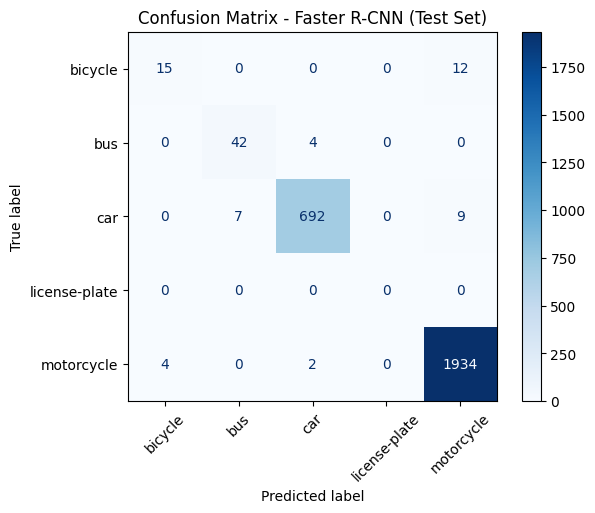

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]
labels = [i+1 for i in range(len(CLASS_NAMES))]  # 1..5

cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=CLASS_NAMES
)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Faster R-CNN (Test Set)")
plt.xticks(rotation=45)
plt.show()

#### plotting percentages in confusion matrix

invalid value encountered in divide


<Figure size 800x600 with 0 Axes>

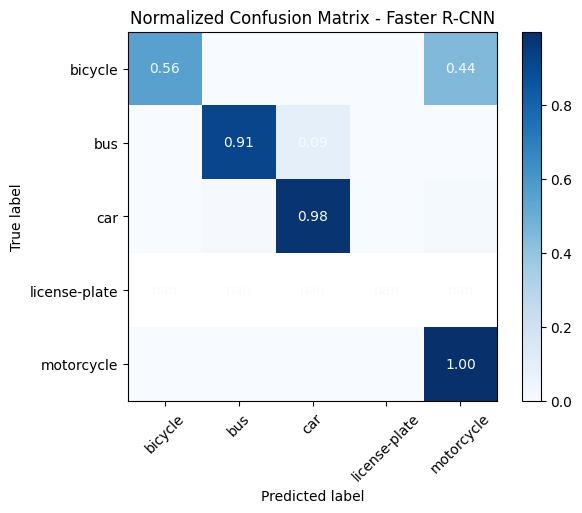

In [71]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized,
    display_labels=CLASS_NAMES
)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='.2f')
plt.title("Normalized Confusion Matrix - Faster R-CNN")
plt.xticks(rotation=45)
plt.show()

Its valid to not show any measure for license plate. Its dataset doesnt have any annotations to learn for License plate its not model problem.

In [72]:
plt.savefig("confusion_matrix_faster_rcnn.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

### MAP calculation on each vehicle class

In [73]:
def evaluate_map_per_class(model, dataloader, device, coco_gt, class_names):

    model.eval()
    results = []

    with torch.no_grad():
        for images, targets in dataloader:

            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):

                image_id = target["image_id"].item()

                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):

                    if score < 0.5:
                        continue

                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1

                    results.append({
                        "image_id": image_id,
                        "category_id": int(label - 1),  # 0–4
                        "bbox": [float(x1), float(y1), float(width), float(height)],
                        "score": float(score)
                    })

    coco_pred = coco_gt.loadRes(results)
    from pycocotools.cocoeval import COCOeval

    coco_eval = COCOeval(coco_gt, coco_pred, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()

    precisions = coco_eval.eval["precision"]
    iou_idx = np.where(coco_eval.params.iouThrs == 0.5)[0][0]

    per_class_map = {}

    for class_id, class_name in enumerate(class_names):

        precision = precisions[iou_idx, :, class_id, 0, -1]
        precision = precision[precision > -1]

        if len(precision) == 0:
            ap = 0
        else:
            ap = np.mean(precision)

        per_class_map[class_name] = ap

    return per_class_map

In [74]:
CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]

per_class_map = evaluate_map_per_class(
    model,
    test_loader,
    device,
    coco_test,
    CLASS_NAMES
)

print("\n========== Per-class mAP (IoU=0.5) ==========\n")
for cls, ap in per_class_map.items():
    print(f"{cls:20} : {ap:.4f}")

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.95s).
Accumulating evaluation results...
DONE (t=0.09s).

========== Per-class mAP (IoU=0.5) ==========

bicycle              : 0.4156
bus                  : 0.7034
car                  : 0.8529
license-plate        : 0.0000
motorcycle           : 0.8124


#### Calculate and visualize the precesion recall curve and F1-scores after Model model evaluations

In [75]:
from sklearn.preprocessing import label_binarize

def get_detection_classification_scores(model, dataloader, device,
                                         iou_threshold=0.5, conf_threshold=0.001):

    model.eval()

    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, targets in dataloader:

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):

                pred_boxes = output["boxes"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()

                true_boxes = target["boxes"].cpu().numpy()
                true_labels = target["labels"].cpu().numpy()

                matched_true = set()

                # For each prediction
                for pb, pl, ps in zip(pred_boxes, pred_labels, pred_scores):

                    if ps < conf_threshold:
                        continue

                    best_iou = 0
                    best_gt_idx = -1

                    # Match with GT
                    for j, tb in enumerate(true_boxes):

                        if j in matched_true:
                            continue

                        iou = calculate_iou(pb, tb)

                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = j

                    if best_iou >= iou_threshold and best_gt_idx != -1:
                        y_true.append(true_labels[best_gt_idx])
                        y_scores.append(ps)
                        matched_true.add(best_gt_idx)
                    else:
                        y_true.append(0)  # Background
                        y_scores.append(ps)

                # false negatives
                for j, tl in enumerate(true_labels):
                    if j not in matched_true:
                        y_true.append(tl)
                        y_scores.append(0.0)

    return np.array(y_true), np.array(y_scores)

In [76]:
CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]

y_true, y_scores = get_detection_classification_scores(
    model,
    test_loader,
    device,
    iou_threshold=0.5
)

# Convert to binary matrix (one column per class)
y_true_bin = label_binarize(y_true, classes=[1,2,3,4,5])
n_classes = y_true_bin.shape[1]

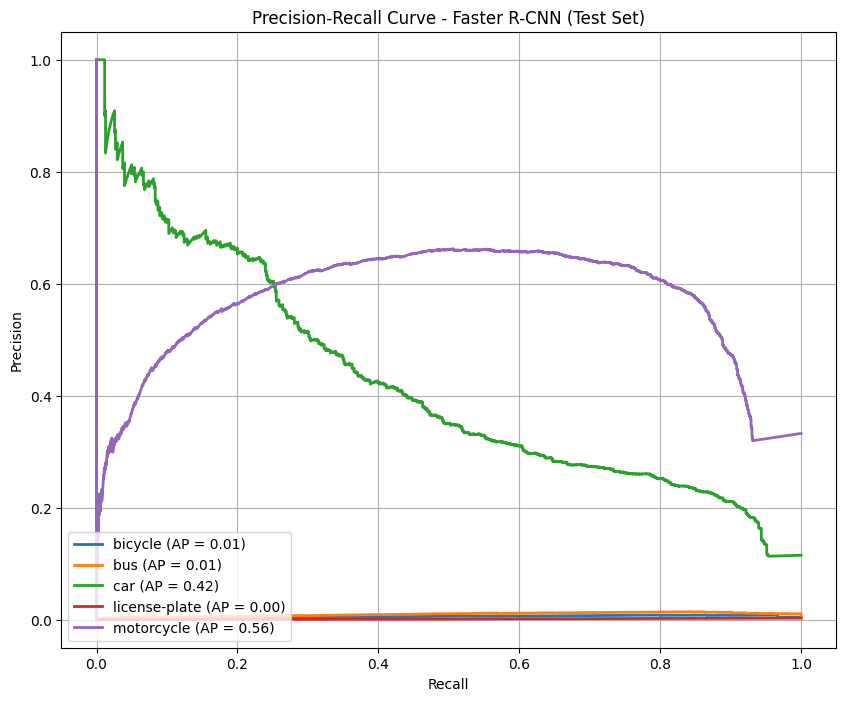

In [77]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

for i, cls_name in enumerate(CLASS_NAMES):

    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores)

    ap = average_precision_score(y_true_bin[:, i], y_scores)

    plt.plot(recall, precision, lw=2,
             label=f"{cls_name} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Faster R-CNN (Test Set)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

#### Visualizing the sample predictions to test the model on test samples

In [78]:
# Load best model for inference (only once)
import torch
import cv2
import matplotlib.pyplot as plt

# Load best trained model
model.load_state_dict(torch.load("best_faster_rcnn_vehicle_detector.pt"))
model.to(device)
model.eval()

CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]

In [81]:
# Function to visualize predictions on a single image
def visualize_prediction_with_class_counts(model, image_path, device, conf_thresh=0.5):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_tensor = torch.tensor(image / 255., dtype=torch.float32).permute(2,0,1).to(device)

    with torch.no_grad():
        output = model([img_tensor])[0]

    boxes  = output["boxes"].cpu().numpy()
    labels = output["labels"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    plt.figure(figsize=(10,8))
    plt.imshow(image)
    plt.axis("off")

    # Initialize class-wise counter
    class_counts = {cls: 0 for cls in CLASS_NAMES}
    total_count = 0

    for box, label, score in zip(boxes, labels, scores):

        if score < conf_thresh:
            continue

        total_count += 1

        x1, y1, x2, y2 = box
        class_name = CLASS_NAMES[label - 1]

        # Update class counter
        class_counts[class_name] += 1

        # Draw box
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            edgecolor="red",
            linewidth=2
        )
        plt.gca().add_patch(rect)

        # Add label
        plt.text(
            x1,
            y1 - 5,
            f"{class_name} {score:.2f}",
            color="yellow",
            fontsize=11,
            backgroundcolor="black"
        )

    #  Show total detections on image
    plt.title(f"Detected Vehicles: {total_count}")
    plt.show()

    # Print class-wise count neatly
    print("\n------ Vehicle Count by Class ------")
    for cls, cnt in class_counts.items():
        print(f"{cls:15} : {cnt}")
    print("------------------------------------\n")

    # Also return the dictionary (useful for Streamlit later)
    return class_counts, total_count


Showing predictions for: Pho-Hue-Tran-Khat-Chan_7h30-8-9-22_0036_jpg.rf.4770fa34c8db8274633fc8970fc548d9.jpg


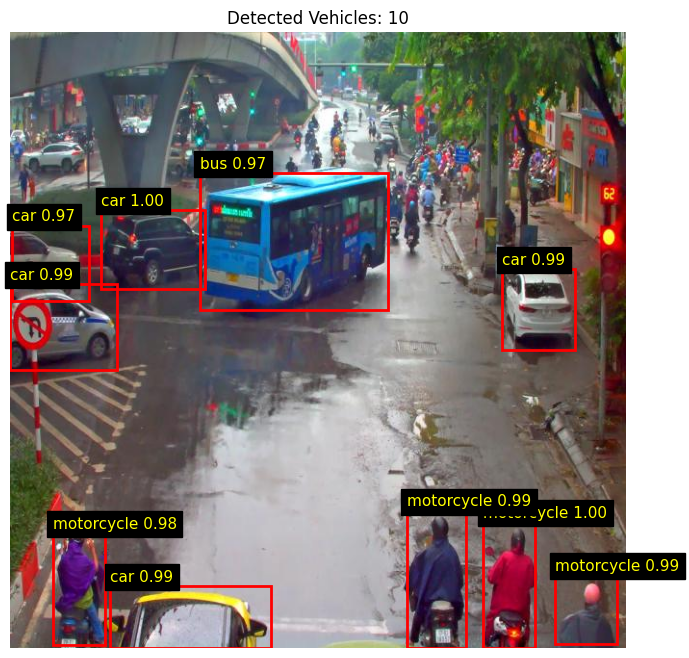


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 1
car             : 5
license-plate   : 0
motorcycle      : 4
------------------------------------


Showing predictions for: Le-Duan-Nguyen-Thai-Hoc_16h15-25-9-22_0019_jpg.rf.c548e90c2d54b2b3092e3a02fbd32375.jpg


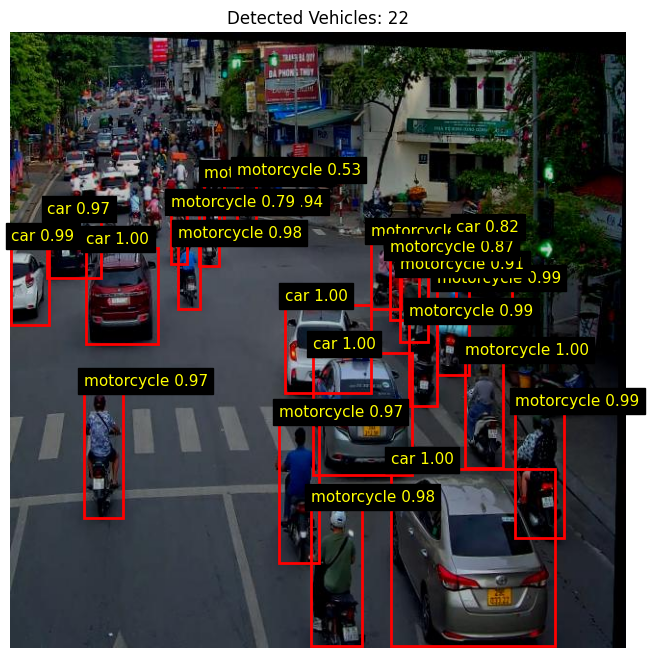


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 7
license-plate   : 0
motorcycle      : 15
------------------------------------


Showing predictions for: Hang-Bong-Hang-Trong_16h-30-25-9-22_0047_jpg.rf.8fe244001ea7208254f3464a2a6a90bb.jpg


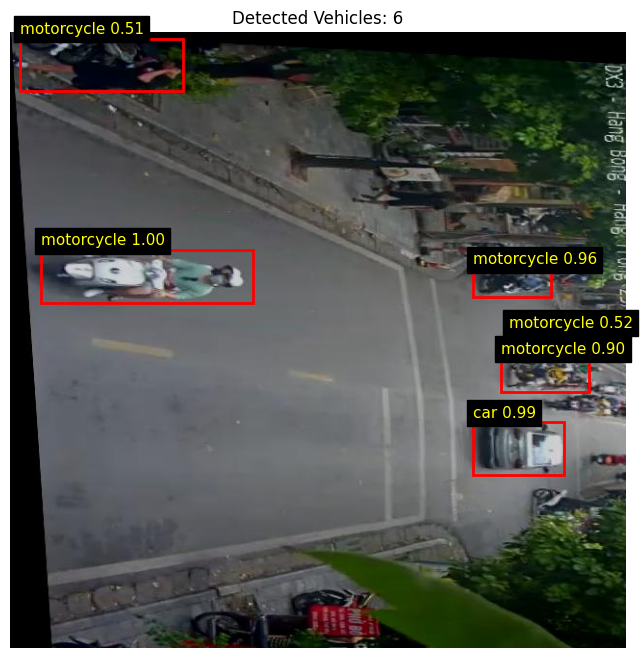


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 1
license-plate   : 0
motorcycle      : 5
------------------------------------


Showing predictions for: Lang-Ha-Thai-Ha-1-_16h-25-9-22_0052_jpg.rf.831e7266220b70b3dbfb717d64935f09.jpg


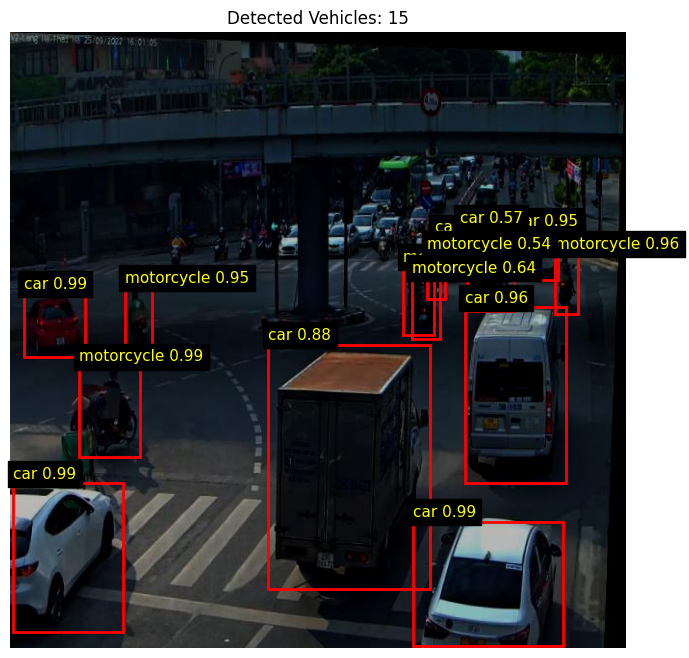


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 9
license-plate   : 0
motorcycle      : 6
------------------------------------


Showing predictions for: Le-Duan-Nguyen-Thai-Hoc_16h-15-9-22_0056_jpg.rf.32a2c45fafa06bbea9cda9f261e35e56.jpg


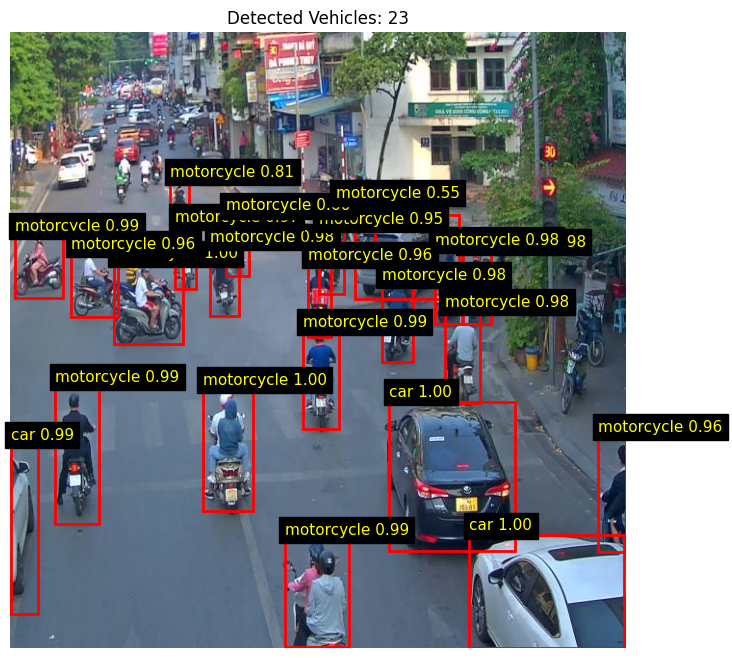


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 4
license-plate   : 0
motorcycle      : 19
------------------------------------



In [83]:
import random
import os

test_img_dir = "small_dataset/test/images"
test_images = os.listdir(test_img_dir)

# Pick 5 random test images
for img_name in random.sample(test_images, 5):

    img_path = os.path.join(test_img_dir, img_name)

    print(f"\nShowing predictions for: {img_name}")
    visualize_prediction_with_class_counts(model, img_path, device, conf_thresh=0.5)